In [701]:
## setup analysis
import numpy as np
import cv2
from matplotlib import pyplot as plt
execfile(r'D:\measuring\analysis\scripts\setup_analysis.py')
filename = r'D:\measuring\Labview\CCDcamera\Bitmarker_field_of_view.dat'
# filename = r'D:\measuring\Labview\CCDcamera\Bitmarker_and_stripline.dat'
%matplotlib inline
from itertools import compress
from analysis.lib.image_analysis import camera_tools as ct; reload(ct)

<module 'analysis.lib.image_analysis.camera_tools' from 'd:/measuring\analysis\lib\image_analysis\camera_tools.py'>

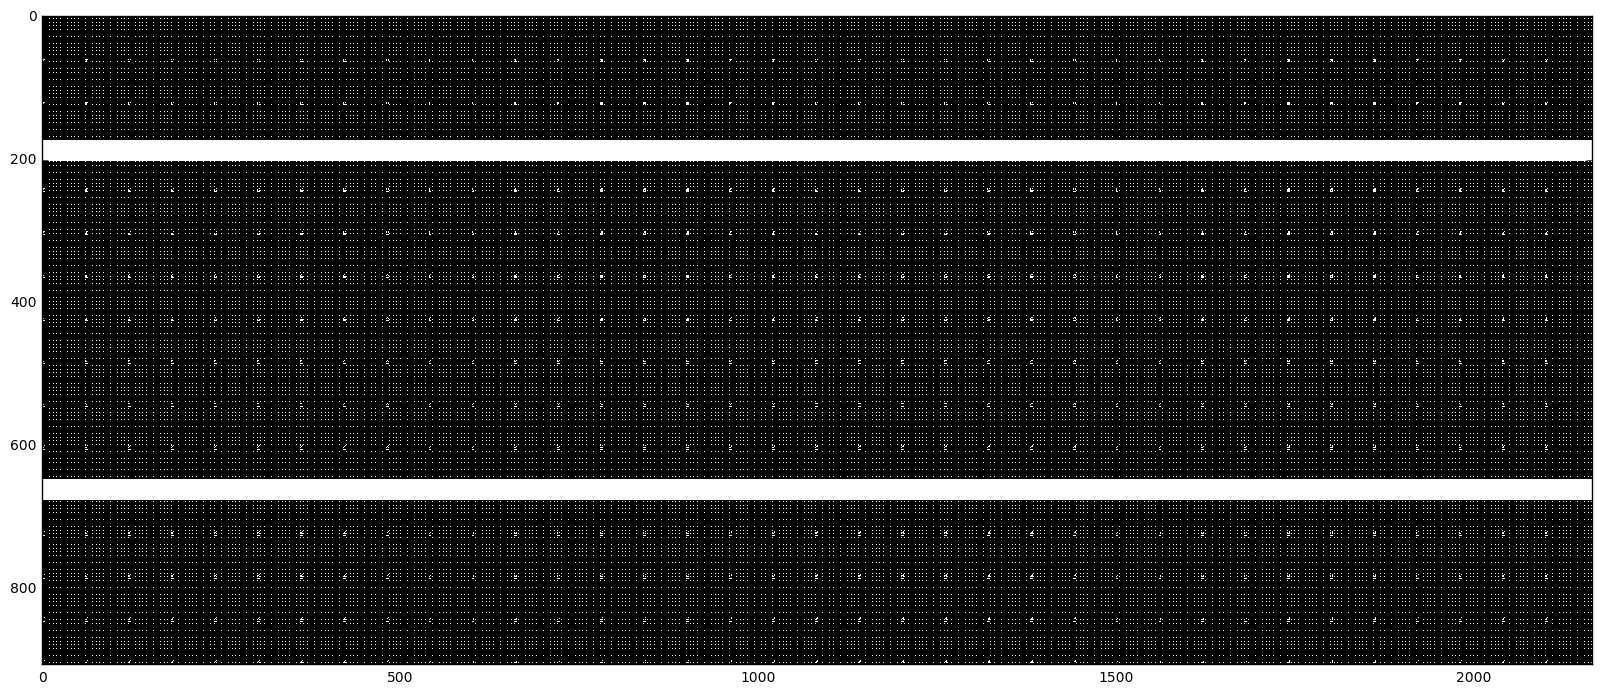

In [702]:
### create the ebeam pattern as a numpy array
### resolution is automatically assumed to be 1 um. You can easiliy extend this by using np.kron(pattern,np.ones((5,5))).
# the example above is for a resolution of 200 nm.

#### numbers for hillary x_max 35; y_max = 14; bitm_pitch = 60; small_marker_pitch = 5; markersize = 1

Hillary_ebeam_pattern = ct.generate_marker_pattern(small_marker_pitch=5,
                                                            bit_x_max = 36,bit_y_max = 15,pitch_bitm = 60)
Hillary_ebeam_pattern = ct.add_striplines_to_img(Hillary_ebeam_pattern,stripline_width = 30,stripline_centre = [240+4,244+474])
##### our entire ebeam pattern (excluding bondpads)
ct.show_image(Hillary_and_line,size=20,no_col_bar=True)

(150, 150)
[[  4.01317925e-02   9.99194395e-01  -5.89892815e+00]
 [ -9.99194395e-01   4.01317925e-02   2.93859390e+02]]


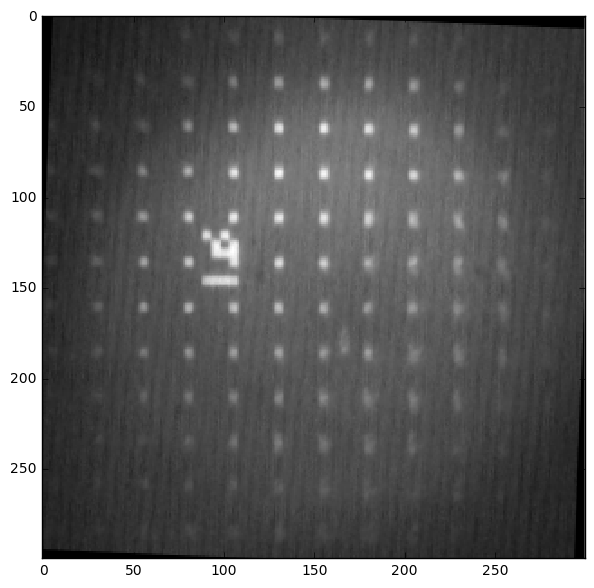

In [692]:
### do some fast image loading via numpy
array2d = np.loadtxt(filename,delimiter='\t',ndmin = 2)
# show_image(array2d)
array_prepared = ct.stamp_out_relevant_field_of_view(ct.apply_brightness_filter(array2d,0)) ## cut out background
array_prepared = ct.rotate_image(array_prepared,90-2.3)#-1.36)

### 70 is good for bit marker resolution
### 60 is good for marker resolution
# ct.show_image(array_prepared)
laplacian = cv2.Laplacian(array_prepared,cv2.CV_64F,ksize=21)
laplacian = (laplacian-(np.amax(laplacian)+np.amin(laplacian))/2.) ## centre around 0
laplacian = 2*laplacian/(np.amax(laplacian)-np.amin(laplacian)) ## normalize to interval of -1 to 1
# show_image(apply_brightness_filter(laplacian,-1.0,threshold_max= 0.2))
filtered_laplacian = ct.apply_brightness_filter(laplacian,-1.0,threshold_max= 0.2)
# ct.show_image(filtered_laplacian)
# ct.make_binary(ct.rescale_to_8_bit_grayscale(array_prepared),120)
# unfiltered_edges = cv2.Canny(ct.rescale_to_8_bit_grayscale(ct.make_binary(ct.rescale_to_8_bit_grayscale(array_prepared),150))
#                                      ,100,185)
ct.show_image(array_prepared,size =7,no_col_bar=True)

45


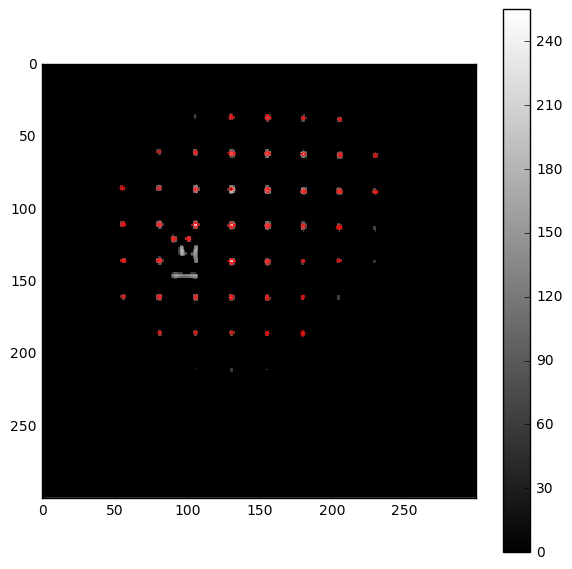

In [693]:
reload(ct)
im_with_keypoints,keypoints,laplace_8bit  = ct.find_marker_grid_via_blob_finder(filtered_laplacian,plot_histogram = False)

ct.show_image(im_with_keypoints,size = 7,no_col_bar=False)

this is the average slope:  -0.000841524439772
this is the average grid distance 24.3417957744
4 5
angle is therefore:  -0.0482157873745


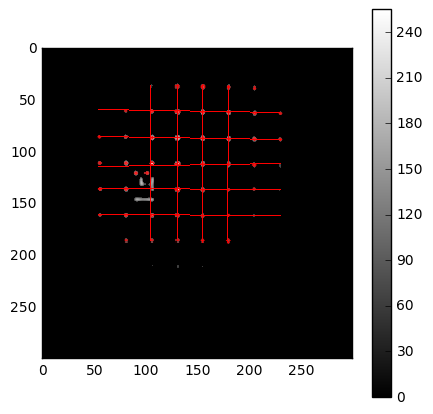

In [694]:
avg_slope,avg_distance,x0,y0 = ct.estimate_grid_from_keypts(im_with_keypoints,keypoints,plot_fitted_lines = True)
print 'angle is therefore: ', np.arctan(avg_slope)*180/np.pi
ct.show_image(im_with_keypoints,size = 5)

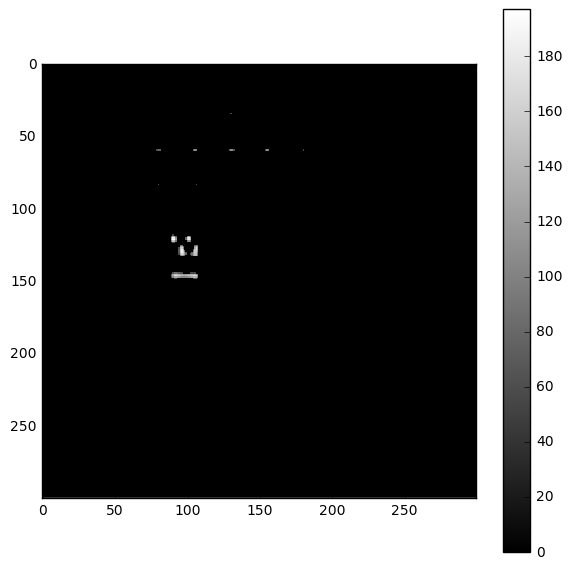

In [695]:
all_marker_pts = ct.get_grid_crossing_pts(x0,y0,avg_slope,avg_distance)
filtered_img = ct.stamp_out_marker_grid_onto_im(laplace_8bit,all_marker_pts,5,show_images = False)
ct.show_image(filtered_img)

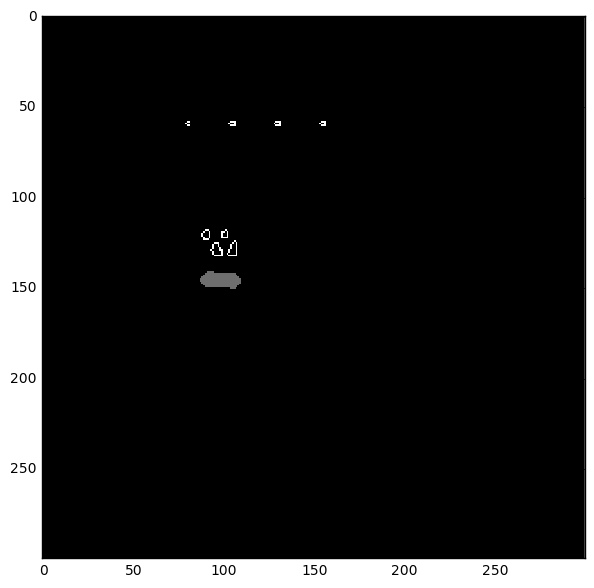

-1 -10


In [700]:
reload(ct)
bit_x,bit_y = ct.find_bit_marker_in_image(filtered_img,do_plot = True)
cent_x,cent_y = np.shape(filtered_img)
laserspot_x,laserspot_y = ct.distance_bitm_and_laserspot(bit_x,bit_y,cent_x,cent_y)
print laserspot_x,laserspot_y

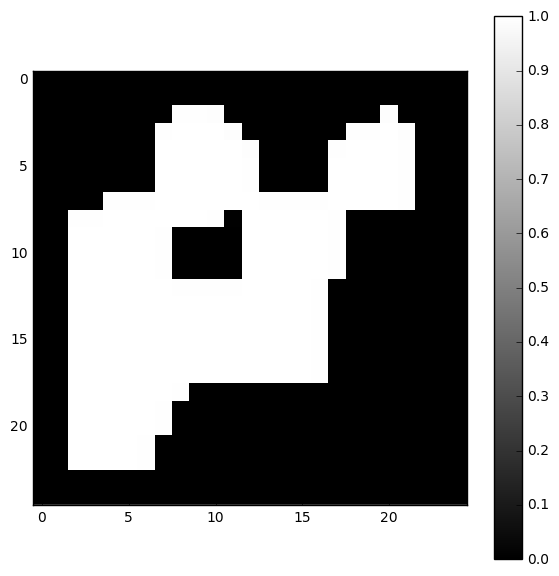

32.0 11.0


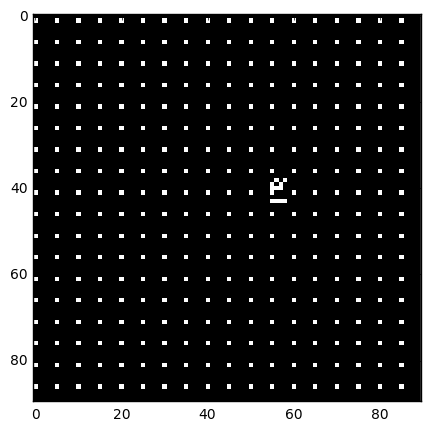

In [644]:
reload(ct)
binary_bit_marker = ct.zoom_in_on_bitmarker(array_prepared,bit_x,bit_y)
ct.show_image(np.fliplr(binary_bit_marker))
bitmarker_array = np.flipud(np.reshape(ct.get_bit_marker_array(binary_bit_marker),(4,4)))
bitx,bity  = ct.get_bitm_xy_from_array(bitmarker_array)

print bitx,bity
ct.show_image(ct.pattern_zoom_on_bitm(Hillary_ebeam_pattern,bitx,bity,rel_size = 1.5,rel_shift_y = laserspot_x,rel_shift_x = laserspot_y),size=5,no_col_bar = True)

2.0


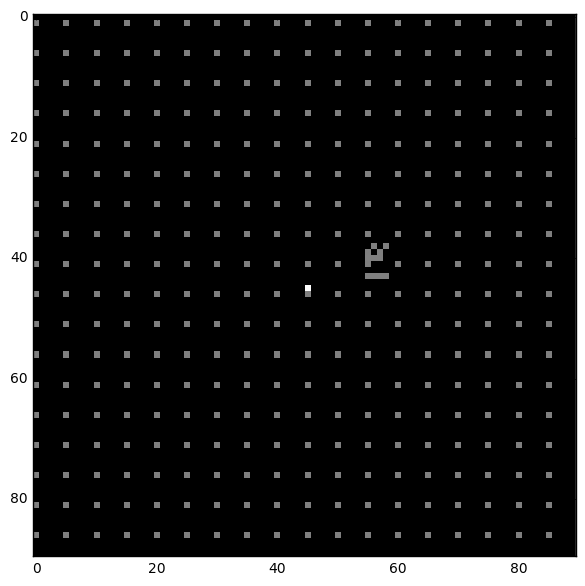

In [645]:
reload(ct)
Hillary_w_NV = ct.draw_spot_onto_pattern(Hillary_ebeam_pattern,2,bitx,bity,laserspot_y,laserspot_x)
Zoom_on_NV = ct.pattern_zoom_on_bitm(Hillary_w_NV.astype(int),bitx,bity,rel_size = 1.5,rel_shift_y = laserspot_x,rel_shift_x = laserspot_y)
ct.show_image(Zoom_on_NV,no_col_bar=True)

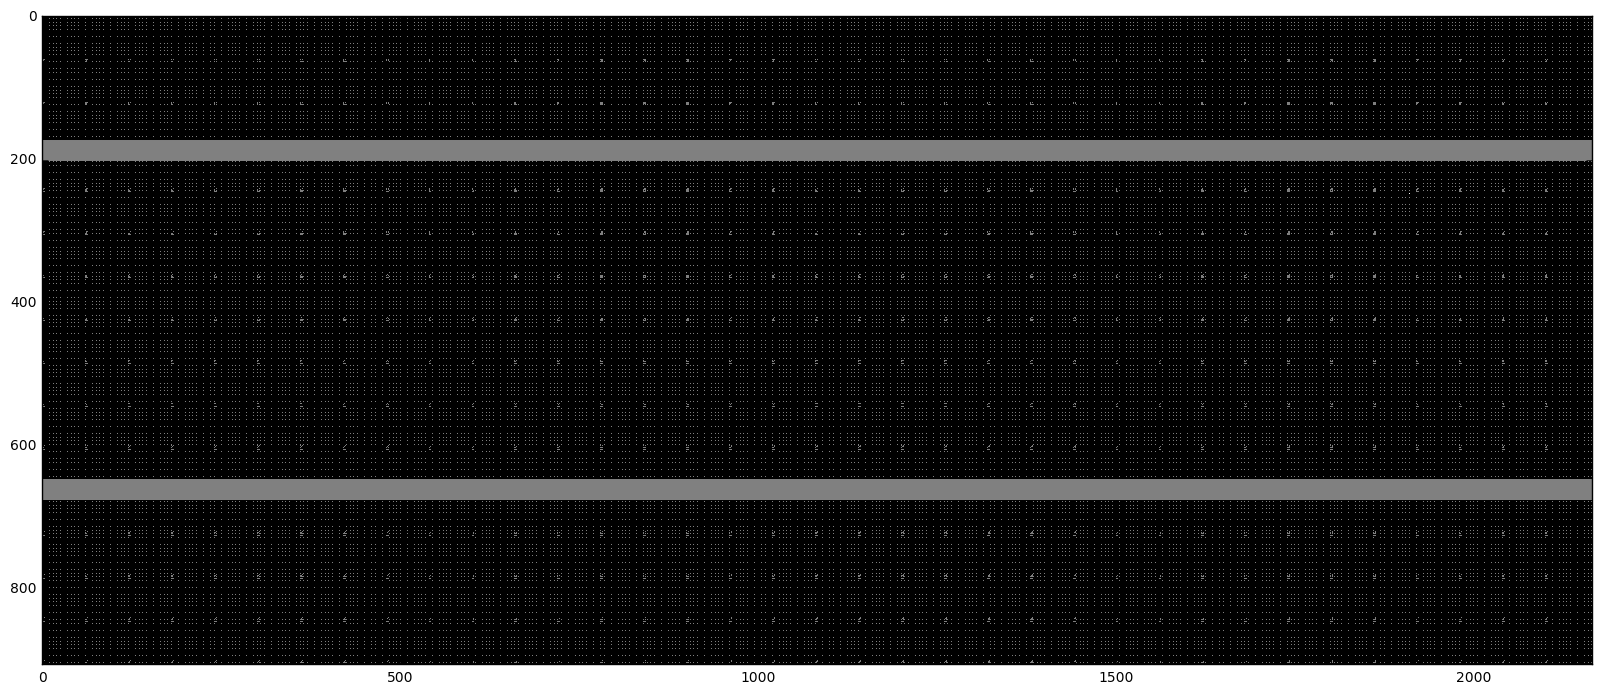

In [646]:
ct.show_image(Hillary_w_NV,size=20,no_col_bar=True)